In [1]:
#Allocating GPU for the models resource

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 0 0 1 2 1 0 2 1 0 1 0 2 0 0 0 2 0 2 0 0 2 1 0 2 0 2 1 2]


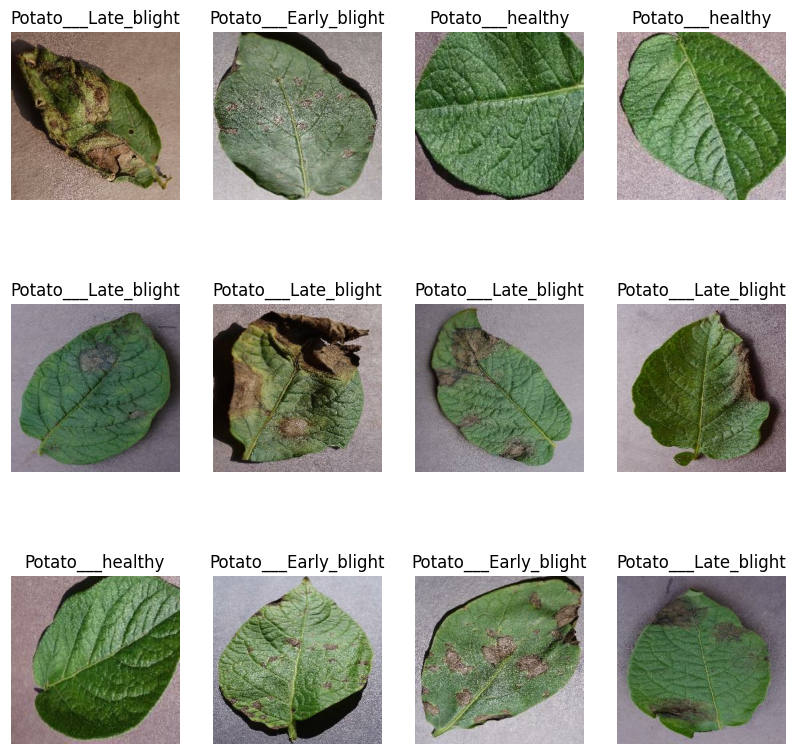

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

94

In [8]:
train_size = 0.8
len(dataset)*train_size

75.2

In [9]:
train_ds = dataset.take(75)
len(train_ds)

75

In [10]:
test_ds = dataset.skip(75)
len(test_ds)

19

In [11]:
val_size=0.1
len(dataset)*val_size

9.4

In [12]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [13]:
test_ds = test_ds.skip(9)
len(test_ds)

10

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
print("Training Dataset Size: ", len(train_ds))
print("Validation Dataset Size: ", len(val_ds))
print("Test Dataset Size: ", len(test_ds))

Training Dataset Size:  75
Validation Dataset Size:  9
Test Dataset Size:  10


In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [20]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
75/75 [==============================] - 161s 1s/step - loss: 0.9390 - accuracy: 0.5059 - val_loss: 0.5721 - val_accuracy: 0.7674
Epoch 2/50
75/75 [==============================] - 89s 1s/step - loss: 0.5966 - accuracy: 0.7207 - val_loss: 0.4831 - val_accuracy: 0.7674
Epoch 3/50
75/75 [==============================] - 91s 1s/step - loss: 0.4693 - accuracy: 0.8018 - val_loss: 0.3608 - val_accuracy: 0.8403
Epoch 4/50
75/75 [==============================] - 85s 1s/step - loss: 0.3958 - accuracy: 0.8495 - val_loss: 0.3709 - val_accuracy: 0.8472
Epoch 5/50
75/75 [==============================] - 87s 1s/step - loss: 0.2194 - accuracy: 0.9168 - val_loss: 0.3686 - val_accuracy: 0.8854
Epoch 6/50
75/75 [==============================] - 87s 1s/step - loss: 0.1986 - accuracy: 0.9285 - val_loss: 0.2646 - val_accuracy: 0.8854
Epoch 7/50
75/75 [==============================] - 78s 1s/step - loss: 0.1954 - accuracy: 0.9323 - val_loss: 0.3576 - val_accuracy: 0.8819
Epoch 8/50
75/75 [=

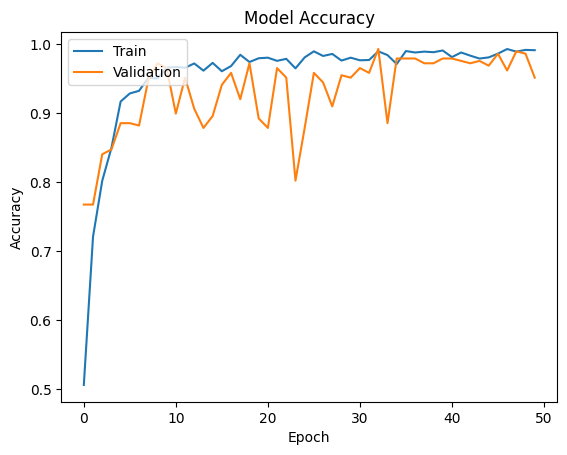

In [24]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")

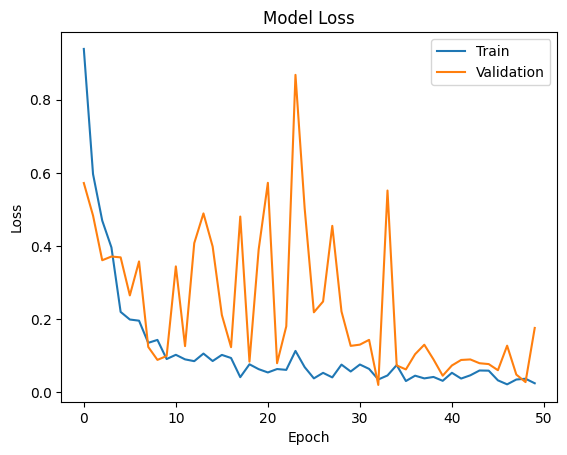

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

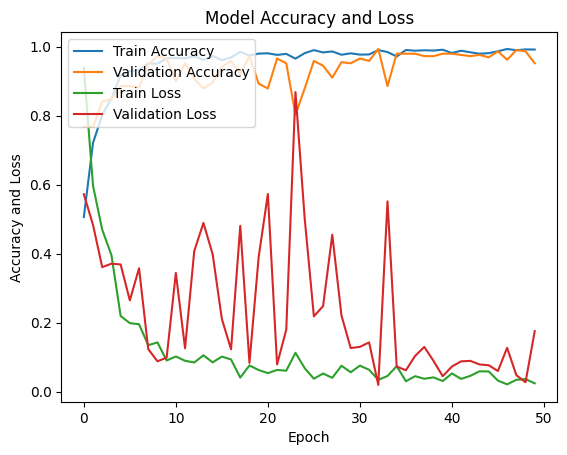

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [27]:
scores = model.evaluate(test_ds)

history.params

history.history['accuracy']

10/10 [==============================] - 13s 41ms/step - loss: 0.2973 - accuracy: 0.9281


[0.5058528184890747,
 0.7207357883453369,
 0.8018394708633423,
 0.8494983315467834,
 0.9168060421943665,
 0.9285116791725159,
 0.9322742223739624,
 0.9510869383811951,
 0.9502508640289307,
 0.9657190442085266,
 0.9669732451438904,
 0.9657190442085266,
 0.9719899892807007,
 0.9615384340286255,
 0.9728260636329651,
 0.9607023596763611,
 0.9682274460792542,
 0.9845317602157593,
 0.9740802645683289,
 0.9795150756835938,
 0.9803511500358582,
 0.9757525324821472,
 0.9786789417266846,
 0.9648829698562622,
 0.9807692170143127,
 0.9895485043525696,
 0.9828595519065857,
 0.985785961151123,
 0.976170539855957,
 0.9803511500358582,
 0.9765886068344116,
 0.9770066738128662,
 0.9895485043525696,
 0.9841136932373047,
 0.9711538553237915,
 0.9899665713310242,
 0.9878762364387512,
 0.989130437374115,
 0.9882943034172058,
 0.9908027052879333,
 0.9811872839927673,
 0.9878762364387512,
 0.9832776188850403,
 0.9790970087051392,
 0.9807692170143127,
 0.9862040281295776,
 0.9928929805755615,
 0.9891304373741

In [28]:
history.history['val_accuracy']

[0.7673611044883728,
 0.7673611044883728,
 0.8402777910232544,
 0.8472222089767456,
 0.8854166865348816,
 0.8854166865348816,
 0.8819444179534912,
 0.9479166865348816,
 0.9722222089767456,
 0.9652777910232544,
 0.8993055820465088,
 0.9513888955116272,
 0.90625,
 0.8784722089767456,
 0.8958333134651184,
 0.9409722089767456,
 0.9583333134651184,
 0.9201388955116272,
 0.9722222089767456,
 0.8923611044883728,
 0.8784722089767456,
 0.9652777910232544,
 0.9513888955116272,
 0.8020833134651184,
 0.8784722089767456,
 0.9583333134651184,
 0.9444444179534912,
 0.9097222089767456,
 0.9548611044883728,
 0.9513888955116272,
 0.9652777910232544,
 0.9583333134651184,
 0.9930555820465088,
 0.8854166865348816,
 0.9791666865348816,
 0.9791666865348816,
 0.9791666865348816,
 0.9722222089767456,
 0.9722222089767456,
 0.9791666865348816,
 0.9791666865348816,
 0.9756944179534912,
 0.9722222089767456,
 0.9756944179534912,
 0.96875,
 0.9861111044883728,
 0.9618055820465088,
 0.9895833134651184,
 0.98611110448

In [29]:
history.history['loss']

[0.9389780163764954,
 0.5966076850891113,
 0.46929702162742615,
 0.395846962928772,
 0.21937234699726105,
 0.19858938455581665,
 0.19539648294448853,
 0.13476994633674622,
 0.14278726279735565,
 0.09044921398162842,
 0.10205917060375214,
 0.089543417096138,
 0.08463501930236816,
 0.10539593547582626,
 0.08497360348701477,
 0.10179107636213303,
 0.09327436983585358,
 0.04079929739236832,
 0.0760735422372818,
 0.06275530904531479,
 0.053736764937639236,
 0.06308028846979141,
 0.06081930547952652,
 0.11270245909690857,
 0.06827561557292938,
 0.03755566477775574,
 0.05266379192471504,
 0.040223728865385056,
 0.07520247250795364,
 0.05635663494467735,
 0.07546403259038925,
 0.0634794682264328,
 0.03452803194522858,
 0.045510198920965195,
 0.07391331344842911,
 0.030246738344430923,
 0.04492338001728058,
 0.037505101412534714,
 0.04143591597676277,
 0.03084033727645874,
 0.05282195284962654,
 0.03703683614730835,
 0.04591399431228638,
 0.05909445881843567,
 0.058641452342271805,
 0.032142836

In [30]:
history.history['val_loss']

[0.5720546841621399,
 0.48313236236572266,
 0.36077240109443665,
 0.3709089756011963,
 0.36863410472869873,
 0.264565646648407,
 0.3575950860977173,
 0.12359508126974106,
 0.08814236521720886,
 0.09877149015665054,
 0.34396663308143616,
 0.12577344477176666,
 0.4075273275375366,
 0.4888978600502014,
 0.3982371687889099,
 0.21093152463436127,
 0.12286194413900375,
 0.4803224205970764,
 0.08332057297229767,
 0.39019811153411865,
 0.5726386308670044,
 0.0790315568447113,
 0.1799040585756302,
 0.8680267930030823,
 0.5024516582489014,
 0.21832668781280518,
 0.24786993861198425,
 0.4548695385456085,
 0.2205972820520401,
 0.126480832695961,
 0.12984895706176758,
 0.14291153848171234,
 0.019628379493951797,
 0.5515530705451965,
 0.07285209745168686,
 0.06204451620578766,
 0.10371357947587967,
 0.12963062524795532,
 0.08937817066907883,
 0.0448673777282238,
 0.07284699380397797,
 0.08790063858032227,
 0.08935259282588959,
 0.07898160815238953,
 0.07662490755319595,
 0.05986612290143967,
 0.1270

In [31]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

Accuracy:  0.9281250238418579
Loss:  0.29734909534454346


In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

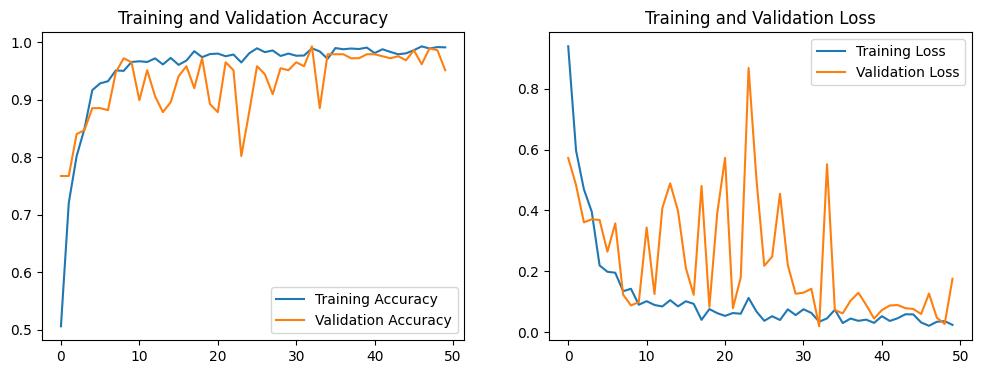

In [33]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image actual label: Potato___Early_blight
1/1 [==============================] - 0s 86ms/step
[9.9999750e-01 2.5424606e-06 3.3892550e-13]
Max Value: 0
Predicted Label: Potato___Early_blight


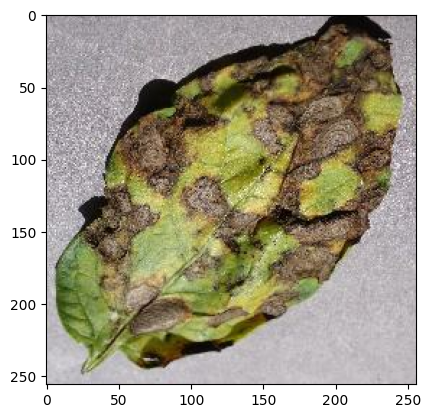

In [42]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


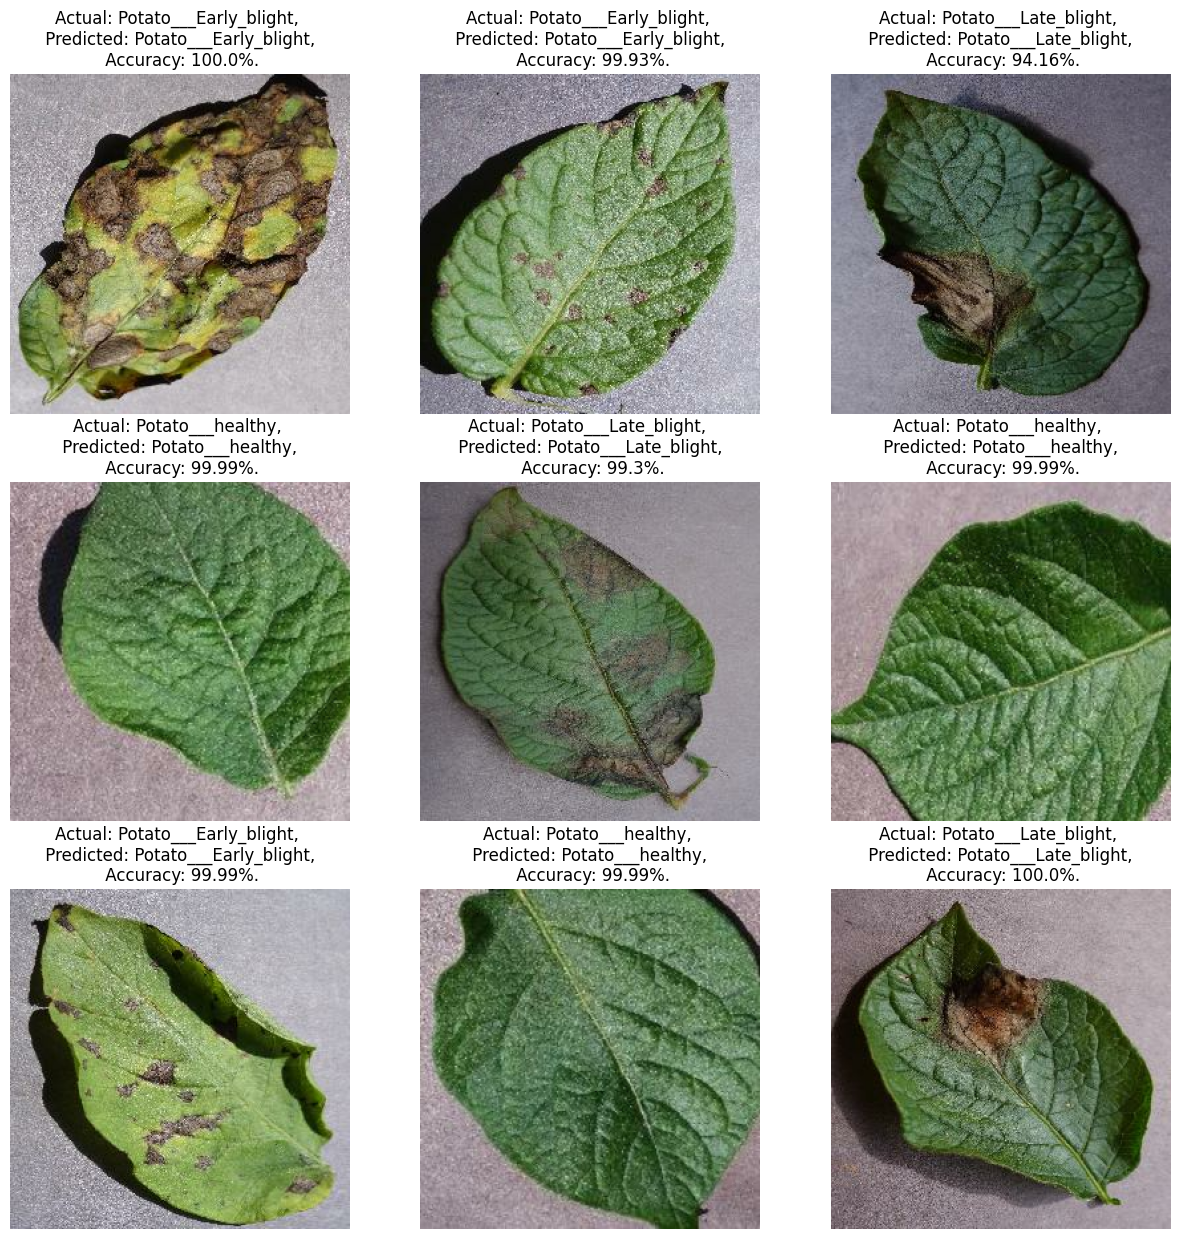

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")  # Setting the title with actual class, predicted class, and confidence
        plt.axis("off")

In [46]:
print("Accuracy: ", scores[1] * 100)

Accuracy:  92.81250238418579


In [47]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(y_true, y_pred, average='weighted') * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100

print("F1 Score: ", f1)
print("Precision Score: ", precision)
print("Recall Score: ", recall)

10/10 [==============================] - 0s 41ms/step
F1 Score:  46.97428229665071
Precision Score:  47.47280974338411
Recall Score:  47.1875


10/10 [==============================] - 0s 37ms/step


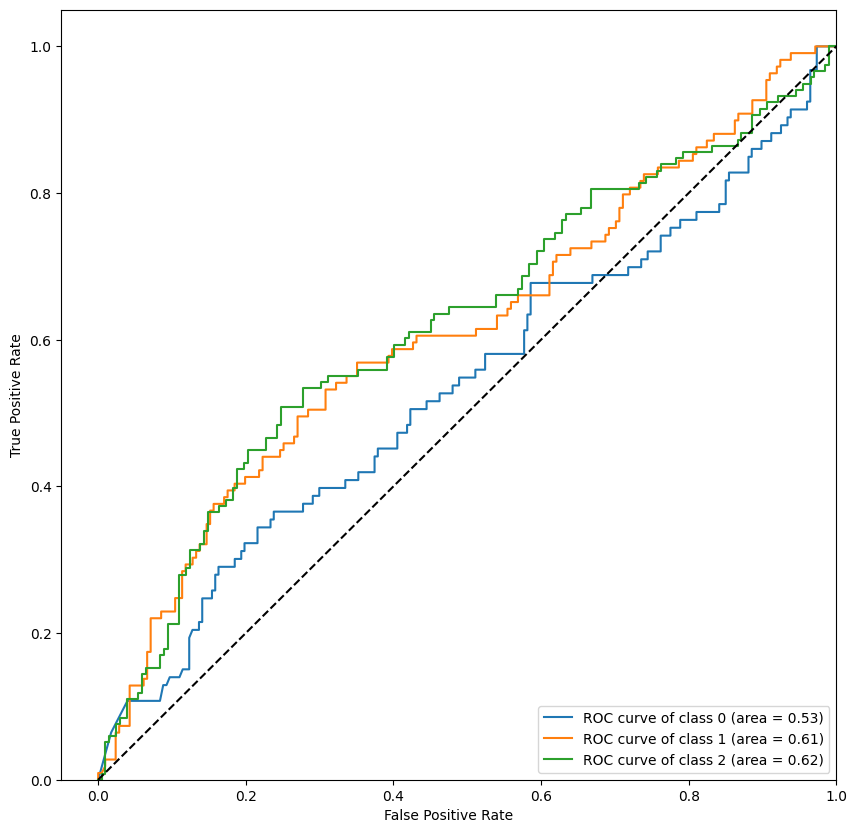

In [48]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

10/10 [==============================] - 0s 35ms/step


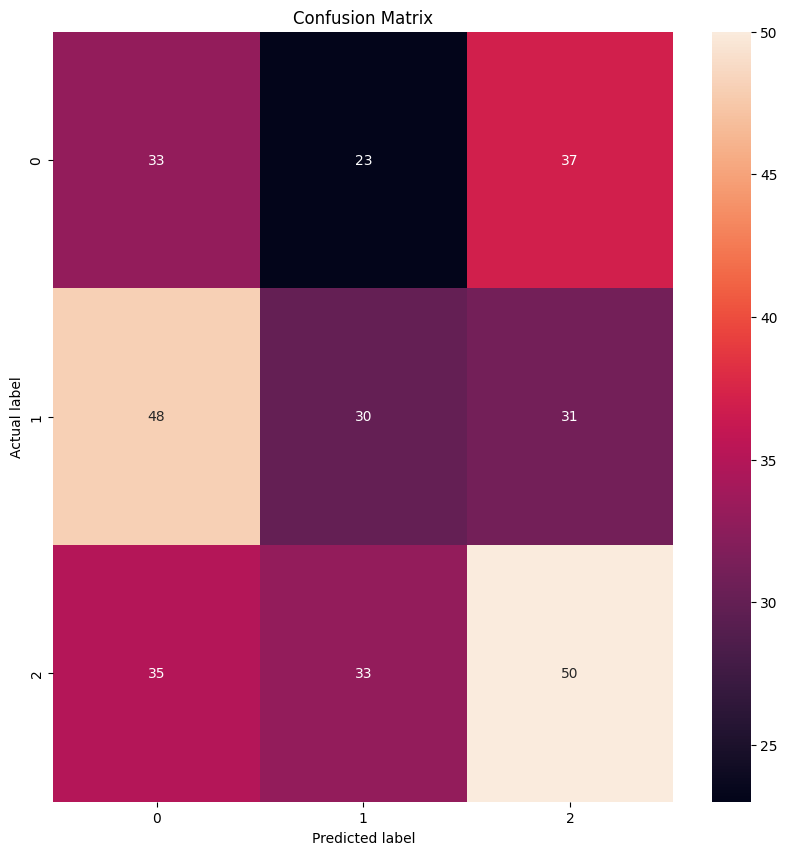

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [50]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()